In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import json
import os

import anndata as ad
import numpy as np
import pandas as pd
import sklearn
import torch
import tqdm

import celltrip


# Load Data and Policy

In [ ]:
# Read data files
# adata_prefix = 's3://nkalafut-celltrip/Dyngen'
adata_prefix = '../data/Dyngen'
adatas = celltrip.utility.processing.read_adatas(
    's3://nkalafut-celltrip/dyngen/logcounts.h5ad',
    's3://nkalafut-celltrip/dyngen/counts_protein.h5ad',
    backed=True)
# Model location and name (should be prefix for .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Dyngen-250920', 800  # 8 dim
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Dyngen-251015', 800  # 32 dim
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Dyngen-251025', 200  # 32 dim, extra feature processing hidden layer
# Generate or load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
    mask = np.loadtxt(f).astype(bool)
adatas[0].obs['Training'] = mask
# Create sample env (kind of a dumb workaround, TODO)
m1, m2 = [preprocessing.transform(ad[:2].X, subset_modality=i)[0] for i, ad in enumerate(adatas)]
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), torch.tensor(m2), compute_rewards=False, dim=32).eval().to('cuda')
# Load policy
policy = celltrip.policy.create_agent_from_env(
    env, forward_batch_size=1_000, vision_size=1_000).eval().to('cuda')
policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


# Perform Significance Estimation

In [4]:
# # Params
# np.random.seed(42)
# genes_to_survey = adatas[0].var_names
# sim_time = 1.

# # Mute warnings (array wrap and indexing)
# import warnings
# warnings.simplefilter('ignore')

# # Create anndata
# ad_pert = ad.AnnData(obs=adatas[0].obs, var=pd.DataFrame(index=[f'Feature {i}' for i in range(env.dim)]))
# # ad_pert0 = ad.AnnData(obs=adatas[0].obs, var=adatas[0].var)
# # ad_pert1 = ad.AnnData(obs=adatas[1].obs, var=adatas[1].var)
# def add_layers(states, gene):
#     ad_pert.layers[gene] = states
#     # ad_pert0.layers[gene] = states_0
#     # ad_pert1.layers[gene] = states_1

# # Add results
# results = []
# def add_record(states, states_0, states_1, gene, ct):
#     results.append({
#         'Gene': gene, 'Cell Type': ct,
#         'Effect Size (Latent)': np.square(states[-1] - states[0]).mean(),
#         'Trajectory Length (Latent)': np.square(states[1:] - states[:-1]).mean(axis=(-2, -1)).sum(),
#         'Effect Size (Modality 0)': np.square(states_0[-1] - states_0[0]).mean(),
#         'Trajectory Length (Modality 0)': np.square(states_0[1:] - states_0[:-1]).mean(axis=(-2, -1)).sum(),
#         'Effect Size (Modality 1)': np.square(states_1[-1] - states_1[0]).mean(),
#         'Trajectory Length (Modality 1)': np.square(states_1[1:] - states_1[:-1]).mean(axis=(-2, -1)).sum()})
    
# # Reset function
# def reset_env(env, steady_pos, steady_vel, modal_dict={}):
#     env.set_max_time(sim_time).reset()  # TODO: Maybe longer?, early stopping?
#     env.set_positions(steady_pos)
#     env.set_velocities(steady_vel)  # Maybe 0 manually?
#     for k, v in modal_dict.items():
#         env.modalities[k] = v

# # Running function
# def run_and_record(samples, env, policy, preprocessing, gene, gene_idx):
#     # Run and impute
#     states = celltrip.train.simulate_until_completion(
#         env, policy,
#         env_hooks=[
#             celltrip.utility.hooks.clamp_inverted_features_hook(
#                 gene_idx, preprocessing, feature_targets=0., modality_idx=0),
#         ],
#         action_hooks=[
#             celltrip.utility.hooks.move_toward_targets_hook(
#                 gene_idx, feature_targets=0., pinning=policy.pinning[0],
#                 preprocessing=preprocessing, modality_idx=0,
#                 factor=1, device=env.device),
#         ],
#         store_states='cpu')[-1]
#     states_pos = states[..., :env.dim]
#     with torch.no_grad():
#         imputed_states_0 = policy.pinning[0](states_pos.to('cuda')).detach().cpu().numpy()
#         imputed_states_1 = policy.pinning[1](states_pos.to('cuda')).detach().cpu().numpy()
#     imputed_states_0, = preprocessing.inverse_transform(imputed_states_0, subset_modality=0)
#     imputed_states_1, = preprocessing.inverse_transform(imputed_states_1, subset_modality=1)
#     # Record
#     add_layers(states_pos.numpy()[-1], gene)  # , imputed_states_0[-1], imputed_states_1[-1]
#     add_record(states_pos.numpy(), imputed_states_0, imputed_states_1, gene, 'All')
#     for ct in adatas[0][samples].obs['traj_sim'].unique():
#         add_record(
#             states_pos[:, adatas[0][samples].obs['traj_sim']==ct].numpy(),
#             imputed_states_0[:, adatas[0][samples].obs['traj_sim']==ct],
#             imputed_states_1[:, adatas[0][samples].obs['traj_sim']==ct],
#             gene, ct)

# # Subset and preprocess the data
# samples = adatas[0].obs.index
# raw_m1 = celltrip.utility.processing.chunk_X(adatas[0][samples], chunk_size=2_000)
# m1, m2 = [
#     celltrip.utility.processing.chunk_X(
#         ad[samples], chunk_size=2_000,
#         func=lambda x: preprocessing.transform(x, subset_modality=i)[0])
#         for i, ad in enumerate(adatas)]

# # Initialize environment
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), torch.tensor(m2), compute_rewards=False, dim=env.dim).eval(time_scale=1).to('cuda')

# # Simulate to steady state
# env.reset()
# celltrip.train.simulate_until_completion(env, policy)
# steady_pos, steady_vel = (env.pos, env.vel)

# # Run control
# reset_env(env, steady_pos, steady_vel)
# add_layers(steady_pos.cpu().numpy(), 'Steady')
# run_and_record(samples, env, policy, preprocessing, 'Control', [])

# # Perturb
# for gene in tqdm.tqdm(genes_to_survey, miniters=10, maxinterval=30):
#     # Get gene idx and run
#     gene_idx = np.argwhere(adatas[0].var_names==gene).flatten()
#     reset_env(env, steady_pos, steady_vel)  # {0: torch.tensor(m1).cuda()}
#     run_and_record(samples, env, policy, preprocessing, gene, gene_idx)

# # Convert and save
# pd.DataFrame(results).to_csv('../plots/dyngen/knockdown.csv', index=None)
# ad_pert.write_h5ad('../plots/dyngen/knockdown_results.h5ad')
# # ad_pert0.write_h5ad('../plots/dyngen/knockdown_results_modality_0.csv')
# # ad_pert1.write_h5ad('../plots/dyngen/knockdown_results_modality_1.csv')


# Perform Module Knockdown

In [5]:
# Load modules
with celltrip.utility.general.open_s3_or_local('../plots/dyngen/dyngen_tfs.json', 'rb') as f:
    tf_modules = json.load(f)
    tf_modules.pop('NaN')

# Params
np.random.seed(42)
sim_time = 128.

# Mute warnings (array wrap and indexing)
import warnings
warnings.simplefilter('ignore')

# Create anndata
ad_pert = ad.AnnData(obs=adatas[0].obs, var=pd.DataFrame(index=[f'Feature {i}' for i in range(env.dim)]))
# ad_pert0 = ad.AnnData(obs=adatas[0].obs, var=adatas[0].var)
# ad_pert1 = ad.AnnData(obs=adatas[1].obs, var=adatas[1].var)
def add_layers(states, gene):
    ad_pert.layers[gene] = states
    # ad_pert0.layers[gene] = states_0
    # ad_pert1.layers[gene] = states_1

# Add results
results = []
def add_record(states, states_0, states_1, gene, ct):
    results.append({
        'Gene': gene, 'Cell Type': ct,
        'Effect Size (Latent)': np.square(states[-1] - states[0]).mean(),
        'Trajectory Length (Latent)': np.square(states[1:] - states[:-1]).mean(axis=(-2, -1)).sum(),
        'Effect Size (Modality 0)': np.square(states_0[-1] - states_0[0]).mean(),
        'Trajectory Length (Modality 0)': np.square(states_0[1:] - states_0[:-1]).mean(axis=(-2, -1)).sum(),
        'Effect Size (Modality 1)': np.square(states_1[-1] - states_1[0]).mean(),
        'Trajectory Length (Modality 1)': np.square(states_1[1:] - states_1[:-1]).mean(axis=(-2, -1)).sum()})
    
# Reset function
def reset_env(env, steady_pos, steady_vel, modal_dict={}):
    env.set_max_time(sim_time).reset()  # TODO: Maybe longer?, early stopping?
    env.set_positions(steady_pos)
    env.set_velocities(steady_vel)  # Maybe 0 manually?
    for k, v in modal_dict.items():
        env.modalities[k] = v

# Running function
def run_and_record(samples, env, policy, preprocessing, gene, gene_idx):
    # Run and impute
    states = celltrip.train.simulate_until_completion(
        env, policy,
        env_hooks=[
            celltrip.utility.hooks.clamp_inverted_features_hook(
                gene_idx, preprocessing, feature_targets=0., modality_idx=0),
        ],
        action_hooks=[
            celltrip.utility.hooks.move_toward_targets_hook(
                gene_idx, feature_targets=0., pinning=policy.pinning[0],
                preprocessing=preprocessing, modality_idx=0,
                factor=1, device=env.device),
        ],
        skip_states=100, store_states='cpu')[-1]
    states_pos = states[..., :env.dim]
    with torch.no_grad():
        imputed_states_0 = policy.pinning[0](states_pos.to('cuda')).detach().cpu().numpy()
        imputed_states_1 = policy.pinning[1](states_pos.to('cuda')).detach().cpu().numpy()
    imputed_states_0, = preprocessing.inverse_transform(imputed_states_0, subset_modality=0)
    imputed_states_1, = preprocessing.inverse_transform(imputed_states_1, subset_modality=1)
    # Record
    add_layers(states_pos.numpy()[-1], gene)  # , imputed_states_0[-1], imputed_states_1[-1]
    add_record(states_pos.numpy(), imputed_states_0, imputed_states_1, gene, 'All')
    for ct in adatas[0][samples].obs['traj_sim'].unique():
        add_record(
            states_pos[:, adatas[0][samples].obs['traj_sim']==ct].numpy(),
            imputed_states_0[:, adatas[0][samples].obs['traj_sim']==ct],
            imputed_states_1[:, adatas[0][samples].obs['traj_sim']==ct],
            gene, ct)

# Subset and preprocess the data
samples = adatas[0].obs.index
raw_m1 = celltrip.utility.processing.chunk_X(adatas[0][samples], chunk_size=2_000)
m1, m2 = [
    celltrip.utility.processing.chunk_X(
        ad[samples], chunk_size=2_000,
        func=lambda x: preprocessing.transform(x, subset_modality=i)[0])
        for i, ad in enumerate(adatas)]

# Initialize environment
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), torch.tensor(m2), compute_rewards=False, dim=env.dim).eval(time_scale=5).to('cuda')

# Simulate to steady state
env.reset()
celltrip.train.simulate_until_completion(env, policy)
steady_pos, steady_vel = (env.pos, env.vel)

# Run control
reset_env(env, steady_pos, steady_vel)
add_layers(steady_pos.cpu().numpy(), 'Steady')
run_and_record(samples, env, policy, preprocessing, 'Control', [])

# Perturb
for module, genes in (pbar := tqdm.tqdm(tf_modules.items())):
    # Get gene idx and run
    pbar.set_description(module)
    gene_idx = np.argwhere(np.isin(adatas[0].var_names, genes)).flatten()
    reset_env(env, steady_pos, steady_vel)  # {0: torch.tensor(m1).cuda()}
    run_and_record(samples, env, policy, preprocessing, module, gene_idx)

# Convert and save
pd.DataFrame(results).to_csv('../plots/dyngen/knockdown_full.csv', index=None)
ad_pert.write_h5ad('../plots/dyngen/knockdown_full_results.h5ad')



  0%|                                                                                                                                                                                               | 0/62 [00:00<?, ?it/s]


Burn1:   0%|                                                                                                                                                                                        | 0/62 [00:00<?, ?it/s]


Burn1:   2%|██▊                                                                                                                                                                             | 1/62 [00:41<42:13, 41.52s/it]


Burn2:   2%|██▊                                                                                                                                                                             | 1/62 [00:41<42:13, 41.52s/it]


Burn2:   3%|█████▋                                                                                                                                                                          | 2/62 [01:11<34:55, 34.93s/it]


Burn3:   3%|█████▋                                                                                                                                                                          | 2/62 [01:11<34:55, 34.93s/it]


Burn3:   5%|████████▌                                                                                                                                                                       | 3/62 [01:52<36:50, 37.47s/it]


Burn4:   5%|████████▌                                                                                                                                                                       | 3/62 [01:52<36:50, 37.47s/it]


Burn4:   6%|███████████▎                                                                                                                                                                    | 4/62 [02:18<32:02, 33.15s/it]


Burn5:   6%|███████████▎                                                                                                                                                                    | 4/62 [02:18<32:02, 33.15s/it]


Burn5:   8%|██████████████▏                                                                                                                                                                 | 5/62 [02:45<29:07, 30.65s/it]


Burn6:   8%|██████████████▏                                                                                                                                                                 | 5/62 [02:45<29:07, 30.65s/it]


Burn6:  10%|█████████████████                                                                                                                                                               | 6/62 [03:27<32:29, 34.81s/it]


A1:  10%|█████████████████▎                                                                                                                                                                 | 6/62 [03:27<32:29, 34.81s/it]


A1:  11%|████████████████████▏                                                                                                                                                              | 7/62 [03:53<29:12, 31.87s/it]


A2:  11%|████████████████████▏                                                                                                                                                              | 7/62 [03:53<29:12, 31.87s/it]


A2:  13%|███████████████████████                                                                                                                                                            | 8/62 [04:20<27:13, 30.26s/it]


A3:  13%|███████████████████████                                                                                                                                                            | 8/62 [04:20<27:13, 30.26s/it]


A3:  15%|█████████████████████████▉                                                                                                                                                         | 9/62 [04:56<28:17, 32.04s/it]


A4:  15%|█████████████████████████▉                                                                                                                                                         | 9/62 [04:56<28:17, 32.04s/it]


A4:  16%|████████████████████████████▋                                                                                                                                                     | 10/62 [05:39<30:35, 35.31s/it]


A5:  16%|████████████████████████████▋                                                                                                                                                     | 10/62 [05:39<30:35, 35.31s/it]


A5:  18%|███████████████████████████████▌                                                                                                                                                  | 11/62 [06:22<32:00, 37.66s/it]


A6:  18%|███████████████████████████████▌                                                                                                                                                  | 11/62 [06:22<32:00, 37.66s/it]


A6:  19%|██████████████████████████████████▍                                                                                                                                               | 12/62 [06:56<30:40, 36.80s/it]


B1:  19%|██████████████████████████████████▍                                                                                                                                               | 12/62 [06:56<30:40, 36.80s/it]


B1:  21%|█████████████████████████████████████▎                                                                                                                                            | 13/62 [07:37<31:00, 37.98s/it]


B2:  21%|█████████████████████████████████████▎                                                                                                                                            | 13/62 [07:37<31:00, 37.98s/it]


B2:  23%|████████████████████████████████████████▏                                                                                                                                         | 14/62 [08:15<30:24, 38.02s/it]


B3:  23%|████████████████████████████████████████▏                                                                                                                                         | 14/62 [08:15<30:24, 38.02s/it]


B3:  24%|███████████████████████████████████████████                                                                                                                                       | 15/62 [08:47<28:11, 35.99s/it]


B4:  24%|███████████████████████████████████████████                                                                                                                                       | 15/62 [08:47<28:11, 35.99s/it]


B4:  26%|█████████████████████████████████████████████▉                                                                                                                                    | 16/62 [09:19<26:45, 34.90s/it]


B5:  26%|█████████████████████████████████████████████▉                                                                                                                                    | 16/62 [09:19<26:45, 34.90s/it]


B5:  27%|████████████████████████████████████████████████▊                                                                                                                                 | 17/62 [10:09<29:37, 39.49s/it]


C1:  27%|████████████████████████████████████████████████▊                                                                                                                                 | 17/62 [10:09<29:37, 39.49s/it]


C1:  29%|███████████████████████████████████████████████████▋                                                                                                                              | 18/62 [10:49<28:57, 39.50s/it]


C2:  29%|███████████████████████████████████████████████████▋                                                                                                                              | 18/62 [10:49<28:57, 39.50s/it]


C2:  31%|██████████████████████████████████████████████████████▌                                                                                                                           | 19/62 [11:17<26:00, 36.30s/it]


C3:  31%|██████████████████████████████████████████████████████▌                                                                                                                           | 19/62 [11:17<26:00, 36.30s/it]


C3:  32%|█████████████████████████████████████████████████████████▍                                                                                                                        | 20/62 [11:45<23:33, 33.65s/it]


C4:  32%|█████████████████████████████████████████████████████████▍                                                                                                                        | 20/62 [11:45<23:33, 33.65s/it]


C4:  34%|████████████████████████████████████████████████████████████▎                                                                                                                     | 21/62 [12:25<24:19, 35.60s/it]


C5:  34%|████████████████████████████████████████████████████████████▎                                                                                                                     | 21/62 [12:25<24:19, 35.60s/it]


C5:  35%|███████████████████████████████████████████████████████████████▏                                                                                                                  | 22/62 [13:00<23:31, 35.28s/it]


C6:  35%|███████████████████████████████████████████████████████████████▏                                                                                                                  | 22/62 [13:00<23:31, 35.28s/it]


C6:  37%|██████████████████████████████████████████████████████████████████                                                                                                                | 23/62 [13:27<21:17, 32.76s/it]


C7:  37%|██████████████████████████████████████████████████████████████████                                                                                                                | 23/62 [13:27<21:17, 32.76s/it]


C7:  39%|████████████████████████████████████████████████████████████████████▉                                                                                                             | 24/62 [14:01<21:06, 33.32s/it]


C8:  39%|████████████████████████████████████████████████████████████████████▉                                                                                                             | 24/62 [14:01<21:06, 33.32s/it]


C8:  40%|███████████████████████████████████████████████████████████████████████▊                                                                                                          | 25/62 [14:43<22:04, 35.79s/it]


C9:  40%|███████████████████████████████████████████████████████████████████████▊                                                                                                          | 25/62 [14:43<22:04, 35.79s/it]


C9:  42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                       | 26/62 [15:24<22:27, 37.44s/it]


C10:  42%|██████████████████████████████████████████████████████████████████████████▏                                                                                                      | 26/62 [15:24<22:27, 37.44s/it]


C10:  44%|█████████████████████████████████████████████████████████████████████████████                                                                                                    | 27/62 [16:04<22:13, 38.10s/it]


C11:  44%|█████████████████████████████████████████████████████████████████████████████                                                                                                    | 27/62 [16:04<22:13, 38.10s/it]


C11:  45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 28/62 [16:31<19:46, 34.89s/it]


C12:  45%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 28/62 [16:31<19:46, 34.89s/it]


C12:  47%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 29/62 [16:57<17:41, 32.18s/it]


C13:  47%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 29/62 [16:57<17:41, 32.18s/it]


C13:  48%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 30/62 [17:39<18:48, 35.27s/it]


C14:  48%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 30/62 [17:39<18:48, 35.27s/it]


C14:  50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 31/62 [18:06<16:57, 32.81s/it]


D1:  50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 31/62 [18:06<16:57, 32.81s/it]


D1:  52%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 32/62 [18:49<17:52, 35.73s/it]


D2:  52%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 32/62 [18:49<17:52, 35.73s/it]


D2:  53%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 33/62 [19:16<15:57, 33.03s/it]


D3:  53%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 33/62 [19:16<15:57, 33.03s/it]


D3:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 34/62 [19:55<16:18, 34.95s/it]


D4:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 34/62 [19:55<16:18, 34.95s/it]


D4:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 35/62 [20:37<16:41, 37.09s/it]


D5:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 35/62 [20:37<16:41, 37.09s/it]


D5:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 36/62 [21:05<14:52, 34.33s/it]


D6:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 36/62 [21:05<14:52, 34.33s/it]


D6:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 37/62 [21:46<15:07, 36.31s/it]


D7:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 37/62 [21:46<15:07, 36.31s/it]


D7:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 38/62 [22:12<13:18, 33.27s/it]


D8:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 38/62 [22:12<13:18, 33.27s/it]


D8:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 39/62 [22:52<13:33, 35.35s/it]


D9:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 39/62 [22:52<13:33, 35.35s/it]


D9:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 40/62 [23:36<13:50, 37.77s/it]


D10:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 40/62 [23:36<13:50, 37.77s/it]


D10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 41/62 [24:03<12:03, 34.45s/it]


D11:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 41/62 [24:03<12:03, 34.45s/it]


D11:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 42/62 [24:42<11:59, 36.00s/it]


D12:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 42/62 [24:42<11:59, 36.00s/it]


D12:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 43/62 [25:23<11:52, 37.49s/it]


D13:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 43/62 [25:23<11:52, 37.49s/it]


D13:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 44/62 [25:50<10:16, 34.26s/it]


D14:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 44/62 [25:50<10:16, 34.26s/it]


D14:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 45/62 [26:17<09:04, 32.01s/it]


E1:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 45/62 [26:17<09:04, 32.01s/it]


E1:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 46/62 [26:49<08:34, 32.17s/it]


E2:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 46/62 [26:49<08:34, 32.17s/it]


E2:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 47/62 [27:33<08:55, 35.72s/it]


E3:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 47/62 [27:33<08:55, 35.72s/it]


E3:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 48/62 [28:00<07:43, 33.10s/it]


E4:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 48/62 [28:00<07:43, 33.10s/it]


E4:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 49/62 [28:42<07:45, 35.85s/it]


E5:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 49/62 [28:42<07:45, 35.85s/it]


E5:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 50/62 [29:23<07:28, 37.38s/it]


F1:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 50/62 [29:23<07:28, 37.38s/it]


F1:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 51/62 [29:58<06:43, 36.70s/it]


F2:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 51/62 [29:58<06:43, 36.70s/it]


F2:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 52/62 [30:41<06:23, 38.35s/it]


F3:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 52/62 [30:41<06:23, 38.35s/it]


F3:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 53/62 [31:08<05:14, 34.90s/it]


F4:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 53/62 [31:08<05:14, 34.90s/it]


F4:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 54/62 [31:49<04:55, 36.95s/it]


F5:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 54/62 [31:49<04:55, 36.95s/it]


F5:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 55/62 [32:16<03:57, 33.90s/it]


F6:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 55/62 [32:16<03:57, 33.90s/it]


F6:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 56/62 [32:51<03:24, 34.08s/it]


G1:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 56/62 [32:51<03:24, 34.08s/it]


G1:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 57/62 [33:32<03:01, 36.23s/it]


G2:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 57/62 [33:32<03:01, 36.23s/it]


G2:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 58/62 [34:06<02:22, 35.70s/it]


G3:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 58/62 [34:06<02:22, 35.70s/it]


G3:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 59/62 [34:32<01:38, 32.77s/it]


G4:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 59/62 [34:32<01:38, 32.77s/it]


G4:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 60/62 [35:11<01:09, 34.70s/it]


G5:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 60/62 [35:11<01:09, 34.70s/it]


G5:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 61/62 [35:46<00:34, 34.63s/it]


G6:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 61/62 [35:46<00:34, 34.63s/it]


G6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [36:18<00:00, 34.02s/it]


G6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [36:18<00:00, 35.14s/it]

## Preview

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load modules
with celltrip.utility.general.open_s3_or_local('../plots/dyngen/dyngen_tfs.json', 'rb') as f:
    tf_modules = json.load(f)
    tf_modules.pop('NaN')

# Load perturbations
ad_pert = ad.read_h5ad('../plots/dyngen/knockdown_full_results.h5ad')
control_gex, = preprocessing.inverse_transform(policy.pinning[0](torch.tensor(ad_pert.layers['Control']).cuda()).detach().cpu().numpy(), subset_modality=0)

# Load module
module_pivot = []
for module in tf_modules.keys():
    pert_gex, = preprocessing.inverse_transform(policy.pinning[0](torch.tensor(ad_pert.layers[module]).cuda()).detach().cpu().numpy(), subset_modality=0)
    effect_sizes = pd.DataFrame(index=adatas[0].obs.index)
    effect_sizes['Trajectory'] = adatas[0].obs['traj_sim']
    effect_sizes['Effect Size'] = np.sqrt(np.square(pert_gex - control_gex).mean(axis=-1))
    # tf_mask, tg_mask = adatas[0].var['is_tf'], ~adatas[0].var['is_tf']
    tf_mask, tg_mask, hk_mask = adatas[0].var['is_tf']*~adatas[0].var['is_hk'], ~adatas[0].var['is_tf']*~adatas[0].var['is_hk'], adatas[0].var['is_hk']
    effect_sizes['TF Effect Size'] = np.sqrt(np.square(pert_gex[..., tf_mask] - control_gex[..., tf_mask]).mean(axis=-1))
    effect_sizes['TG Effect Size'] = np.sqrt(np.square(pert_gex[..., tg_mask] - control_gex[..., tg_mask]).mean(axis=-1))
    effect_sizes['HK Effect Size'] = np.sqrt(np.square(pert_gex[..., hk_mask] - control_gex[..., hk_mask]).mean(axis=-1))
    effect_sizes_pivot = effect_sizes[['Trajectory', 'TF Effect Size', 'TG Effect Size', 'HK Effect Size']].melt(id_vars='Trajectory', var_name='Type', value_name='Effect Size')
    effect_sizes_pivot['Type'] = effect_sizes_pivot['Type'].str.split(' ').apply(lambda a: a[0])
    effect_sizes_pivot['Module'] = module
    module_pivot.append(effect_sizes_pivot)
module_pivot = pd.concat(module_pivot, axis=0)
module_pivot = module_pivot.reset_index(drop=True)

In [6]:
# # Get means and stds
# group_cols = ['Module', 'Type']
# grouped_means = module_pivot.groupby(group_cols, observed=True)[['Effect Size']].mean()
# grouped_stds = module_pivot.groupby(group_cols, observed=True)[['Effect Size']].std()

# # Normalize mean
# module_pivot[['Effect Size']] = (
#     module_pivot[['Effect Size']]
#     - grouped_means.loc[
#         list(
#             module_pivot[group_cols]
#                 .itertuples(name=None, index=False))].reset_index(drop=True))

# # Normalize std
# module_pivot[['Effect Size']] = (
#     module_pivot[['Effect Size']]
#     / grouped_stds.loc[
#         list(
#             module_pivot[group_cols]
#                 .itertuples(name=None, index=False))].reset_index(drop=True))

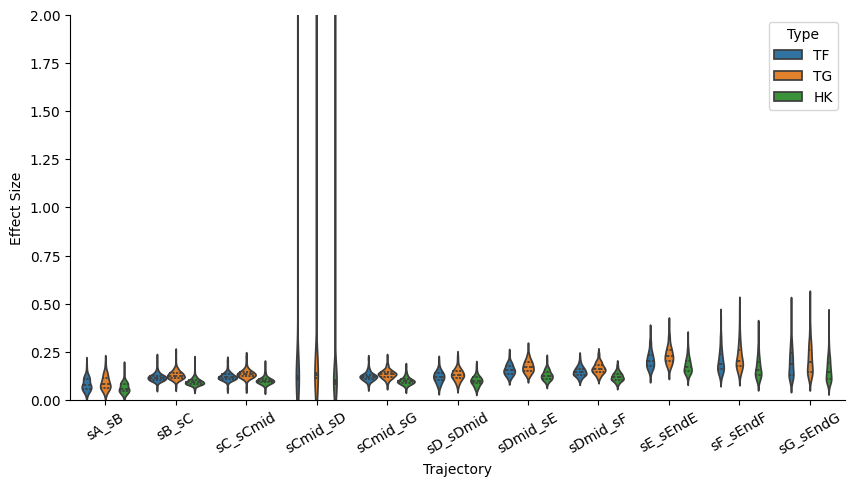

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
df = module_pivot.loc[module_pivot['Module'] == 'A1']
# df = df.groupby(['Trajectory', 'Type'], observed=True)[['Effect Size']].mean().reset_index()
sns.violinplot(df, x='Trajectory', y='Effect Size', hue='Type', split=False, inner='quart', ax=ax)
# sns.boxplot(df, x='Trajectory', y='Effect Size', hue='Type', ax=ax)
# sns.barplot(df, x='Trajectory', y='Effect Size', hue='Type', ax=ax)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_ylim(bottom=0, top=2)
# ax.set_ylim(-.5, .5)
sns.despine(ax=ax)